In [1]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import control as ctr


## Change trigger ID in later function
def upload_file(data_folder, filename,number_of_tags):
    """
    upload SPAD binary file and retrieve timestamps and addreses of each tag in two separate tables 
    """
    global a
    fh =np.fromfile(data_folder+filename,dtype =np.uint8)
    fh1= np.array(fh.reshape(-1,4))
    print(fh1[:8,:])
    fh2 = np.array(np.fliplr(fh1))
    fh3 = np.unpackbits(fh2[1:-1,:]).reshape(-1,32)
    addr = np.array(np.fliplr(fh3[:,0:6]))
    timestamp = np.array(np.fliplr(fh3[:,6:]))
    val_addr = np.packbits(addr,axis=1,bitorder='little')-32
    val_timestamp = np.packbits(timestamp,axis=1,bitorder='little')
    val_timestamps = val_timestamp[:,0]+2**8*val_timestamp[:,1]+2**16*val_timestamp[:,2]+\
                    2**24*val_timestamp[:,3]
    return(trig,val_addr,val_timestamps)
def detector_intensity(val_addr):
    """
    Check intensity of each detector and triggers(position 23 and 24 in return table)
    """
    return(np.unique(val_addr, return_counts=True)[1])
def time_unwrap(val_timestamps):
    """
    Unwrap timestamps into one nondecresing series 
    """
    val_time =val_timestamps.astype('int64')
    for i in range(a-1):
        if val_time[i+1]-val_time[i]<-1*2**25:
            val_time[i+1:]+=2**26
            c+=1
    return(val_time)
def histogram_creation(val_addr,val_timestamps,time_range):
    """
    Creates g2 correlation histogram
    middle row(position time_range)-tags in the same time
    time_range-maximum registered tag difference
    
    """
    hist = np.zeros((23,23,2*time_range+1))
    for i in range(a-1):
        b=1    
        diff = val_time[i+b]-val_time[i]

        while diff<=time_range and diff>=0:

            hist[val_addr[i],val_addr[i+b],time_range+diff]+=1
            hist[val_addr[i+b],val_addr[i],time_range-diff]+=1
            b+=1
            try:
                diff = val_time[i+b]-val_time[i]
            except:
                break
    return(hist)
def calc_correction(mode='create', channels=23,hist=[],counts_detec=[],filename=''):
    """
    mode create - calculate correction parameters and save it in pkl file
    mode upload - upload correction parameters from pkl file
    """
    if mode =='create':
        correction = np. zeros((channels,channels))
        correction_extra  = np. zeros((18,3))
        for i in range(channels):
            for j in range(channels):
                if i!=j:
                    correction[i,j] =(hist[i,j,100]- (hist[i,j,180]/2.+hist[i,j,20]/2.))/(1.*(counts_detec[i]+counts_detec[j]))
                if i+5==j:

                    correction_extra [i,0] =(hist[i,j,101]- (hist[i,j,181]/2.+hist[i,j,21]/2.))/(1.*(counts_detec[i]))
                    correction_extra [i,1] =(hist[i,j,102]- (hist[i,j,182]/2.+hist[i,j,22]/2.))/(1.*(counts_detec[i]))
                    correction_extra [i,2] =(hist[i,j,103]- (hist[i,j,183]/2.+hist[i,j,23]/2.))/(1.*(counts_detec[i]))
        joblib.dump((correction,correction_extra),filename)
        return(correction,correction_extra)
    elif mode == 'upload':
        (correction,correction_extra) =joblib.load(filename)
        return(correction,correction_extra)
def histogram_correction(hist,correction,correction_extra,counts_detec,middle_row):
    """
    Correct histograms using near 0 delay correction parameters
    
    """
    hist_corrected = np.copy(hist)
    for i in range(23):
        for j in range(23):
            if i!=j:
                hist_corrected[i,j,middle_row] -=(counts_detec[i]+counts_detec[j])*correction[i,j]
            if i+5==j:
                hist_corrected[i,j,middle_row+1] -=(counts_detec[i])*correction_extra[i,0]
                hist_corrected[j,i,middle_row-1] -=(counts_detec[i])*correction_extra[i,0]            
                hist_corrected[i,j,middle_row+2] -=(counts_detec[i])*correction_extra[i,1]
                hist_corrected[j,i,middle_row-2] -=(counts_detec[i])*correction_extra[i,1]
                hist_corrected[i,j,middle_row+3] -=(counts_detec[i])*correction_extra[i,2]
                hist_corrected[j,i,middle_row-3] -=(counts_detec[i])*correction_extra[i,2]
    return(hist_corrected)

def scan_points(val_addr,x_points,y_points):
    """
    finding triggers inside tags list and return list of all tags as numpy array
    """
    channels=23
    pixels = np.zeros((y_points,x_points))
    scan_hist = np.zeros((y_points,x_points,channels)) 
    lines = np.where(val_addr==234)[0]

    if lines.shape ==(0,):
        lines = np.array([0,a])
    else:
        lines =np.concatenate((lines,[a]))
    for i in range(y_points):
        part = val_addr[lines[i]:lines[i+1]]
        pix = np.concatenate(([0],np.where(part==233)[0],[lines[i+1]-lines[i]]))
        print(pix)
        if i%2==0:
            pixels[i] = lines[i] + pix[:-1]
        else:
            pixels[i] = lines[i] + np.flip(pix[:-1])
    return(pixels,lines)


def counts_scan(val_addr,val_timestamps,pixels,dwell_time):
    """
    return number of counts of every detector/every pixel in desired dwell time
    dwell time in miliseconds
    """
    dwell_time = int(dwell_time * 1e5)
    x,y = pixels.shape
    counts = np.zeros((x,y,23))
    for i in range(x):
        for j in range(y):
            if i%2 ==0:
                delta= 1
                while val_timestamps[int(pixels[i,j]+delta)]- val_timestamps[int(pixels[i,j])]<dwell_time:
                    if val_addr[int(pixels[i,j]+delta)]<25:
                        counts[i,j,val_addr[int(pixels[i,j]+delta)]] += 1
                        delta += 1
            else:
                delta= 1

                while val_timestamps[int(pixels[i,y-1-j]+delta)]- val_timestamps[int(pixels[i,y-1-j])]<dwell_time:
                    if val_addr[int(pixels[i,y-1-j]+delta)]<25:
                        counts[i,y-1-j,val_addr[int(pixels[i,y-1-j]+delta)]] += 1
                        delta += 1

    return(counts)

def counts_scan_binned(val_addr,val_timestamps,pixels,dwell_time,bin_time):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    """
    dwell_time = int(dwell_time * 1e5)
    bin_time = int(bin_time * 1e5)
    x,y = pixels.shape
    counts = np.zeros((int(np.ceil(dwell_time/bin_time)),x,y,23))
    for i in range(x):
        for j in range(y):
            delta= 0
            if i%2 ==0:
                delta= 1
                while val_timestamps[int(pixels[i,j]+delta)]- val_timestamps[int(pixels[i,j])]<dwell_time:
                    if val_addr[int(pixels[i,j]+delta)]<25:
                        bin_number = int(np.floor((val_timestamps[int(pixels[i,j])+delta]- val_timestamps[int(pixels[i,j])])/bin_time))
                        counts[bin_number,i,j,val_addr[int(pixels[i,j])+delta]] += 1
                        delta += 1
            else:
                delta= 1

                while val_timestamps[int(pixels[i,y-1-j]+delta)]- val_timestamps[int(pixels[i,y-1-j])]<dwell_time:
                    if val_addr[int(pixels[i,y-1-j]+delta)]<25:
                        bin_number = int(np.floor((val_timestamps[int(pixels[i,y-1-j])+delta]- val_timestamps[int(pixels[i,y-1-j])])/bin_time))
                        counts[bin_number,i,y-1-j,val_addr[int(pixels[i,y-1-j])+delta]] += 1
                        delta += 1
    return(counts)


def counts_scan_binned_add(counts,val_addr,val_timestamps,pixels,dwell_time,bin_time):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    Add result to existing counts table
    """

    counts1 = np.zeros(1,(np.ceil(dwell_time/bin_time),x,y,23))
    for i in range(x):
        for j in range(y):
            delta= 0
            while val_timestamps[pixels[i,j]+delta]- val_timestamps[pixels[i,j]]<dwell_time:
                bin_number = np.floor(val_timestamps[pixels[i,j]+delta]- val_timestamps[pixels[i,j]])
                counts1[0,bin_number,i,j,val_addr[pixels[i,j]+delta]] += 1
                delta += 1
    counts = np.concatenate((counts,counts),axis = 0)
    return(counts)        
        
def histogram_plot(val_addr):
    """
    Create a detector heat map for certain range of tags
    """
    pos = np.zeros((val_addr.shape[0],2))
    for i in range(val_addr.shape[0]):
        if i%1e6==0:
            print(i)
        temp=val_addr[i]
        if temp<25:
            if temp<=4:
                pos[i,0]=np.sqrt(3)
                pos[i,1] = temp-2.
            elif temp<=8:
                pos[i,0]=np.sqrt(3)/2.
                pos[i,1] = temp-6.5            
            elif temp<=13:
                pos[i,0]=0
                pos[i,1] = temp-11. 
            elif temp<=17:
                pos[i,0]=-np.sqrt(3)/2.
                pos[i,1] = temp-15.5  
            elif temp<=23:
                pos[i,0]=-np.sqrt(3)
                pos[i,1] = temp-20.
    plt.hexbin(pos[:,1],pos[:,0],gridsize=(4,2))
    plt.colorbar()
    plt.show()
    return(pos)
    

In [4]:
# Processing single pixel data for G2 measurement
#a=20000000                          #number of tags set on SPAD(require before running all functions)
val_addr, val_timestamps  = upload_file(data_folder="./data/NANOspad/2020.06/",filename = "tescik_06_2020_trig",number_of_tags=20000000)
counts_detec=detector_intensity(val_addr)
val_time=time_unwrap(val_timestamps)
correction,correction_extra=calc_correction(mode='upload', channels=23,hist=[],counts_detec=[],filename='correction_parameters_laser.pkl')
hist =  histogram_creation(val_addr,val_timestamps,time_range =100)
hist_corrected = histogram_correction(hist,correction,correction_extra,counts_detec,100)
pos = histogram_plot(val_addr)

[[255 255 255 239]
 [149  16   0 192]
 [247  21   0 156]
 [ 80  25   0 176]
 [ 78  28   0 168]
 [102  37   0 156]
 [ 78  38   0 180]
 [ 47  40   0 156]]


NameError: name 'trig' is not defined

In [ ]:
#intensity scan analysis
#final data- (counts) intensity value of each pixel in every scan point
# format :(x,y,detector)
# times in ms
nanoSPAD_X=20
nanoSPAD_Y=20
val_addr, val_timestamps  = upload_file(data_folder="./data/NANOspad/2020.02/20/",filename = "scan2020",number_of_tags=40000000)
counts_detec=detector_intensity(val_addr)
val_time=time_unwrap(val_timestamps)
points,lines = scan_points(val_addr=val_addr,x_points=nanoSPAD_X+1,y_points = nanoSPAD_Y)
counts = counts_scan(val_addr,val_time,points,dwell_time = 40)

[      0   60104  123144  199557  302234  419681  543061  678430  777993
  855852  953933 1053382 1157322 1265383 1347312 1405555 1462576 1525979
 1598266 1675948 1752863 1823941]
[      0   70842  147481  250912  342770  406578  463809  537069  633437
  738854  853450  982190 1086196 1160835 1257917 1358940 1439507 1513519
 1604694 1708384 1804284 1892176]
[      0   86226  173254  259969  321564  365985  413916  470850  528146
  593917  691299  795204  881996  954981 1025523 1106040 1184689 1275890
 1404090 1528161 1619468 1715893]
[      0  126772  280928  427935  524220  627548  757904  856841  917680
  984238 1060074 1131399 1200484 1271400 1325366 1363840 1406653 1463569
 1532802 1596973 1647642 1696131]
[      0   50852  120020  208220  286277  335921  382371  445060  527958
  608591  668117  725008  784480  845169  924387 1046181 1170608 1249444
 1342074 1499515 1658794 1760308]
[      0  102906  233813  339004  413462  492936  603647  727218  826042
  891782  948703 1007398 10

In [ ]:
plt.plot(val_time)

In [6]:
#intensity scan analysis with time binning
#final data- (counts) intensity value of each pixel in every scan point binned 
# format :(x,y,detector)
# times in ms
nanoSPAD_X=10
nanoSPAD_Y=10
val_addr, val_timestamps  = upload_file(data_folder="./data/NANOspad/2020.06/",filename = "tescik_06_2020_trig",number_of_tags=40000000)
counts_detec=detector_intensity(val_addr)
val_time=time_unwrap(val_timestamps)
points,lines = scan_points(val_addr=val_addr,x_points=nanoSPAD_X+1,y_points = nanoSPAD_Y)
counts = counts_scan_binned(val_addr,val_time,points,dwell_time = 40, bin_time = 5)

[[255 255 255 239]
 [149  16   0 192]
 [247  21   0 156]
 [ 80  25   0 176]
 [ 78  28   0 168]
 [102  37   0 156]
 [ 78  38   0 180]
 [ 47  40   0 156]]


NameError: name 'trig' is not defined

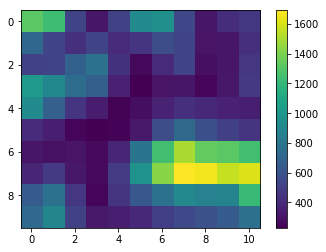

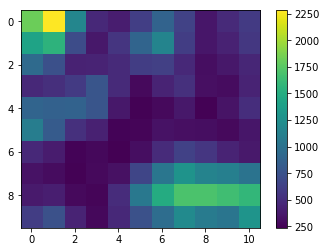

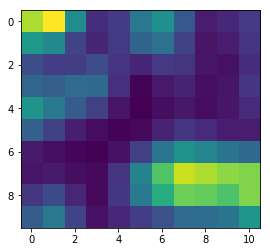

In [29]:
#visualization of 
plt.imshow(counts[:,:,13])
plt.colorbar()
plt.show()
plt.imshow(counts[:,:,9])
plt.colorbar()
plt.show()

plt.imshow(np.sum(counts[:,:,:],axis=2))

In [34]:
#min dead time calculation(VQ=0.85V-approved by Michel to increase VQ until dead time is equal 50 ns)
#recommended in manual VQ= 0.75(left power supply ch 3)
for i in range(23):
    print(i,10*min(np.abs(100-np.where(hist_corrected[i,i,:]>0)[0])),'ns')

NameError: name 'hist_corrected' is not defined

STEP BY STEP CELLS


[[255 255 255 239]
 [ 17  16   0 188]
 [117  16   0 196]
 [177  16   0 168]
 [237  16   0 208]
 [142  17   0 204]
 [201  17   0 188]
 [ 25  18   0 188]]
59065454 (59065454,)
[[1 0 1 ... 0 0 1]
 [1 1 0 ... 1 0 1]
 [1 0 1 ... 0 0 1]
 ...
 [1 1 0 ... 0 0 1]
 [1 1 0 ... 1 0 1]
 [1 0 0 ... 0 0 1]]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17,
       18, 19, 20, 21, 22], dtype=uint8), array([ 536554,  558953, 1727806, 3944353, 3447171,  734478, 2325821,
       6512145, 5573391,  582304, 1787349, 6150945, 3342786, 1162195,
       4979151, 3237924, 1350560, 1102371, 4575609, 3505498, 1535734,
        392356], dtype=int64))


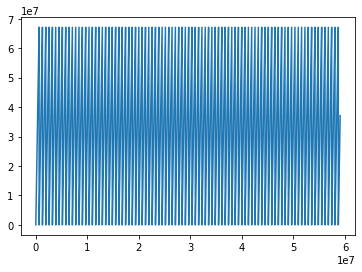

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
data_folder = "./data/master/dark counts and crosstalk/"
filename = "laser_1"

#fh = open(data_folder+filename, "rb")
fh =np.fromfile(data_folder+filename,dtype =np.uint8)

fh1= np.array(fh.reshape(-1,4))
print(fh1[:8,:])
fh2 = np.array(np.fliplr(fh1))
fh3 = np.unpackbits(fh2[1:-1,:]).reshape(-1,32)
trig = np.array(fh3[:,0])
addr = np.array(np.fliplr(fh3[:,0:6]))
timestamp = np.array(np.fliplr(fh3[:,6:]))
val_addr = np.packbits(addr,axis=1,bitorder='little')-32
val_timestamp = np.packbits(timestamp,axis=1,bitorder='little')
val_timestamps = val_timestamp[:,0]+2**8*val_timestamp[:,1]+2**16*val_timestamp[:,2]+\
                2**24*val_timestamp[:,3]
print(sum(trig),trig.shape)
print(fh3)
print(np.unique(val_addr, return_counts=True))
plt.plot(val_timestamps)

In [10]:
indices = [i for i, x in enumerate(val_addr) if x == 240]

In [11]:
indices

[144005233, 164806770]

22
22
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17,
       18, 19, 20, 21, 22], dtype=uint8), array([1730684, 2403462, 4958006, 1633668,  318269, 4489111, 6969017,
       3045941,  795848, 3674196, 5703292, 1759387,  769325,  138779,
       2167224,  623757,  109530, 5373979, 2137893,  891049,  227327,
         88219], dtype=int64))


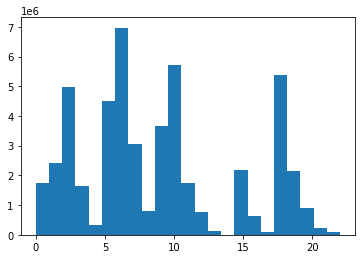

In [36]:
# histogram of channels (chan:0-22-detectors, 30-pixel trigger,31)

print(np.amax(val_addr))
print(val_addr.max())

plt.hist(val_addr,bins =23)
plt.plot()
counts_detec = np.unique(val_addr, return_counts=True)[1]
print(np.unique(val_addr, return_counts=True))

In [5]:
points,lines = scan_points(val_addr=val_addr,x_points=31,y_points =30)

NameError: name 'a' is not defined

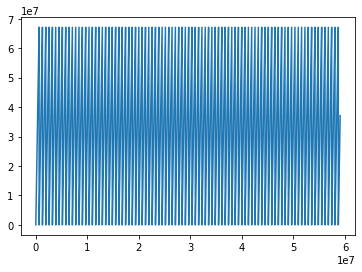

91


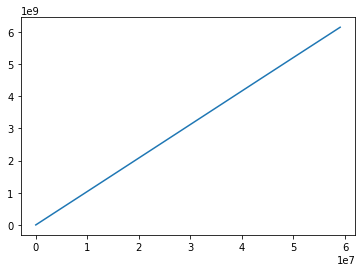

In [41]:
#unwraping time
plt.plot(val_timestamps[:])
plt.show()
c=0
a=val_timestamps.shape[0]
val_time =val_timestamps.astype('int64')
for i in range(a-1):
    if val_time[i+1]-val_time[i]<-1*2**25:
        val_time[i+1:]+=2**26
        c+=1
print(c)
plt.plot(val_time)
plt.show()      

In [11]:
np.log2(max(val_time))
print(max(val_time)/10**8,max(val_timestamps)/10**8)

225.27996499 0.67108862


In [ ]:
points,lines = scan_points(val_addr=val_addr,x_points=11,y_points =10)
counts = counts_scan(val_addr,val_time,points,dwell_time = 200)

In [36]:
points[0,0]

341566.0

In [63]:
counts_binned_1 = counts_scan_binned(val_addr,val_time,points,dwell_time = 400,bin_time=1)

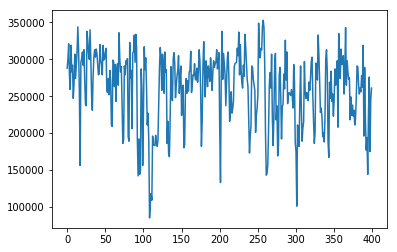

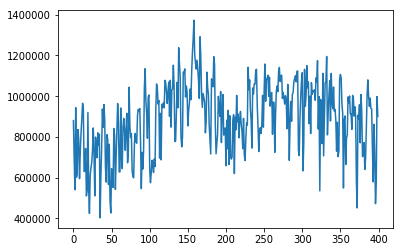

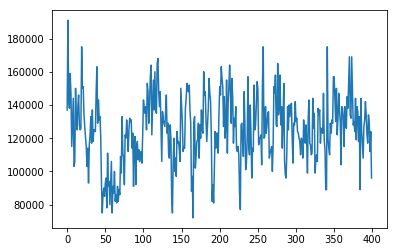

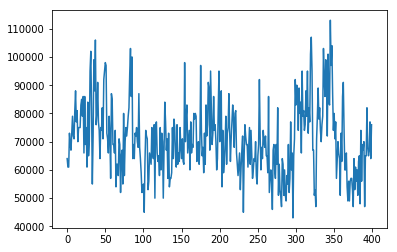

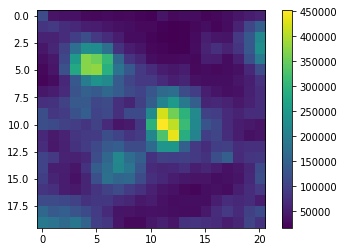

In [69]:
plt.plot(np.sum(counts_binned_1[:,11,7,:],axis=1)*1000)
plt.show()
plt.plot(np.sum(counts_binned_1[:,4,5,:],axis=1)*1000)
plt.show()
plt.plot(np.sum(counts_binned_1[:,14,16,:],axis=1)*1000)
plt.show()
plt.plot(np.sum(counts_binned_1[:,5,16,:],axis=1)*1000)
plt.show()
plt.imshow(np.sum(np.sum(counts_binned_1[:,:,:,:],axis=3),axis=0))
plt.colorbar()
plt.show()

0


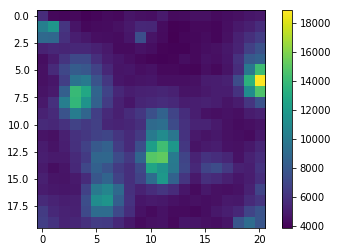

1


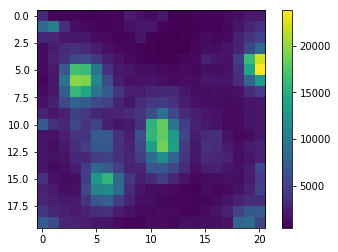

2


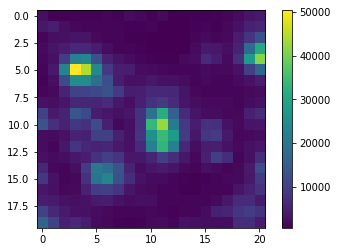

3


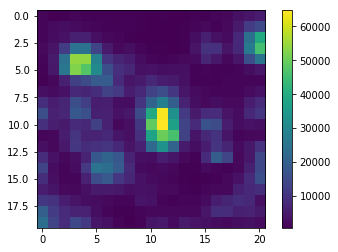

4


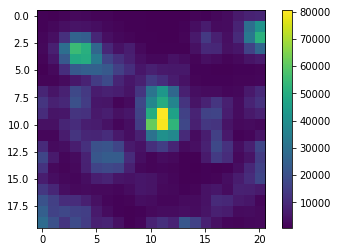

5


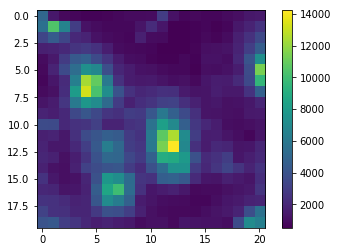

6


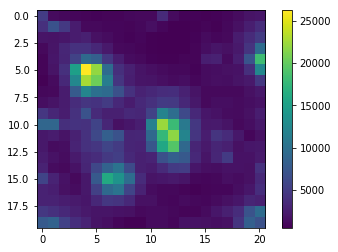

7


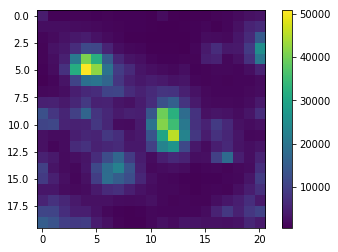

8


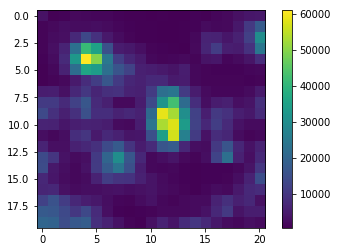

9


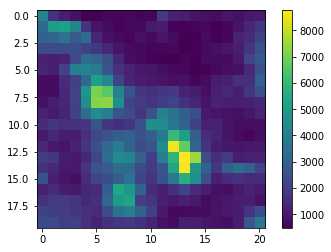

10


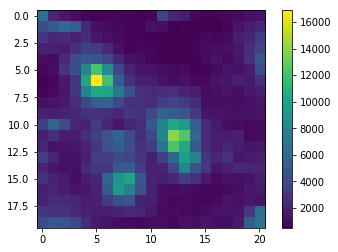

11


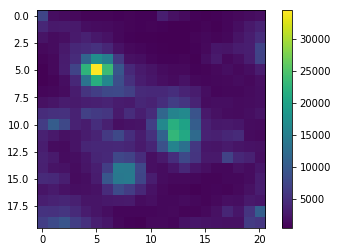

12


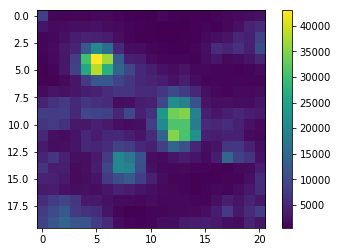

13


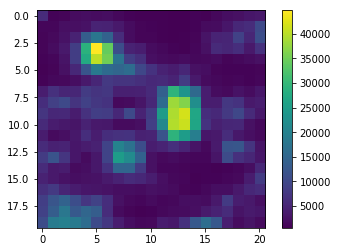

14


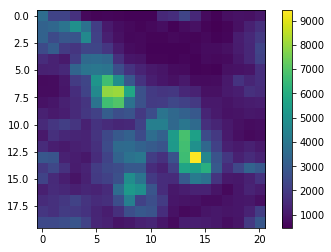

15


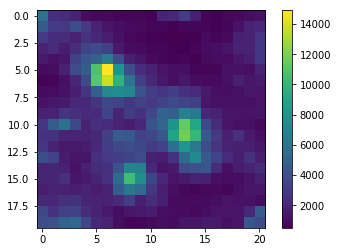

16


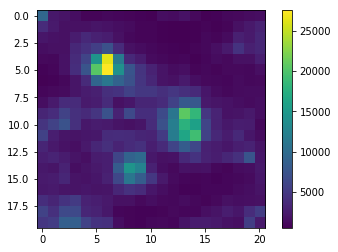

17


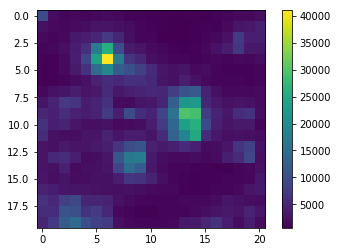

18


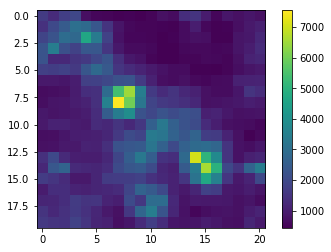

19


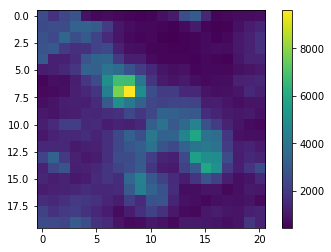

20


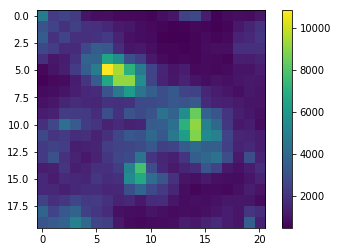

21


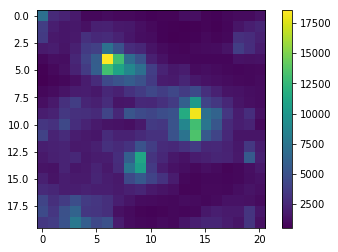

22


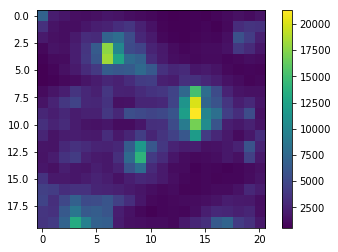

In [46]:
#visualization of
for i in range(23):
    print(i)
    plt.imshow(np.sum(counts_binned[:,:,:,i],axis=0))
    plt.colorbar()
    plt.show()


In [70]:
np.save("C:/Users/PREZES/Documents/stage-control/data/NANOspad/2020.02/26/test_QD_for_Adrian_bin_1000us",counts_binned_1)

In [40]:
counts_detec_a = np.unique(val_addr[:20000000], return_counts=True)[1]
counts_detec_1 = np.concatenate((np.concatenate((counts_detec_a[:14],np.zeros(1))),counts_detec_a[14:]))

In [42]:
#Crosstalk(G2) occurance map
hist = np.zeros((23,23,201))
a= val_time.shape[0]
for i in range(a-1):
    if i%1000000 ==0:
        print(i)
    if i>20000000:
        break
    b=1    
    diff = val_time[i+b]-val_time[i]
    
    while diff<=100 and diff>=0:
        if val_addr[i]<25 and val_addr[i+1]<25:
            hist[val_addr[i],val_addr[i+b],100+diff]+=1
            hist[val_addr[i+b],val_addr[i],100-diff]+=1
            b+=1
            try:
                diff = val_time[i+b]-val_time[i]
            except:
                break


0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000


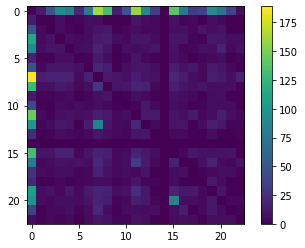

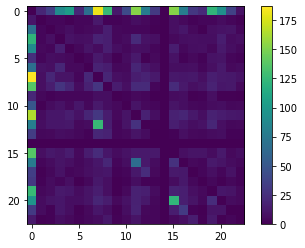

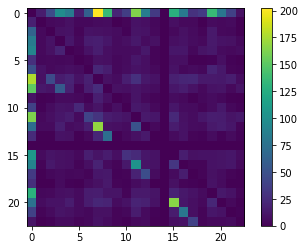

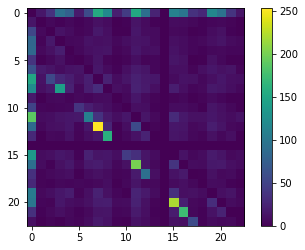

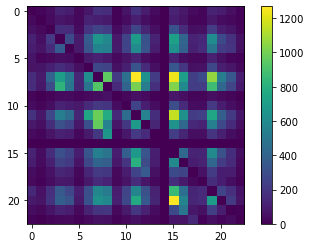

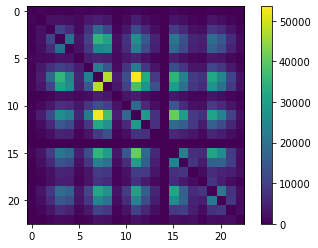

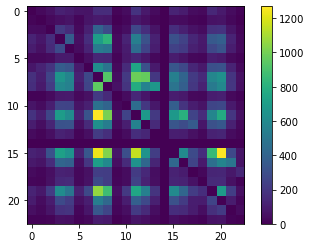

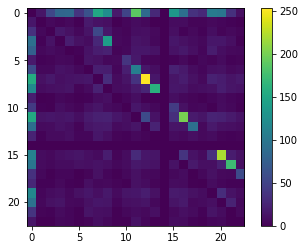

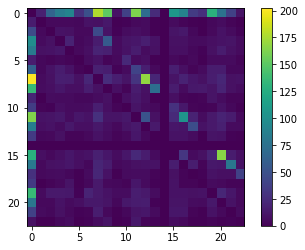

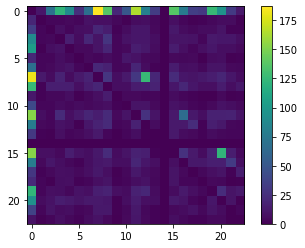

In [43]:
#G2 plot
for i in range(10):
    x=95+i
    plt.imshow((hist[:,:,x]))
    plt.colorbar()
    plt.show()


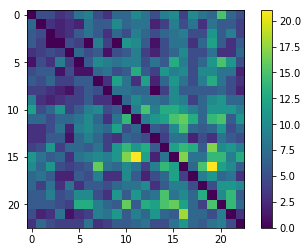

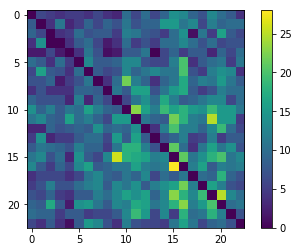

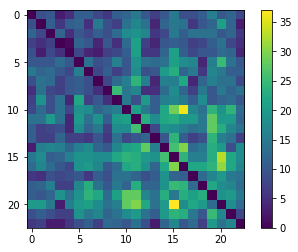

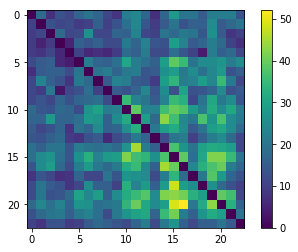

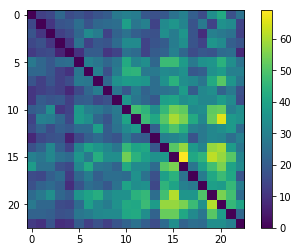

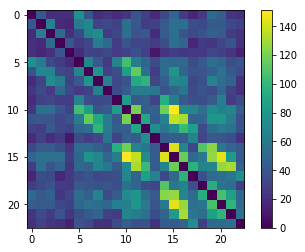

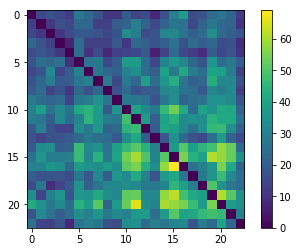

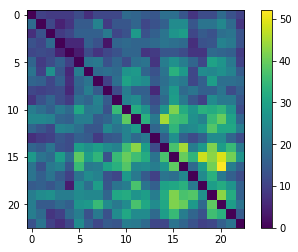

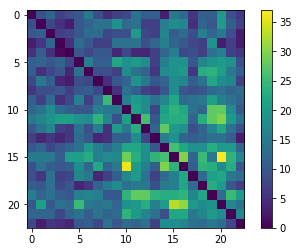

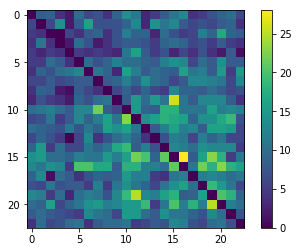

In [36]:
#G2 plot
for i in range(10):
    x=95+i
    plt.imshow((hist[:,:,x]))
    plt.colorbar()
    plt.show()

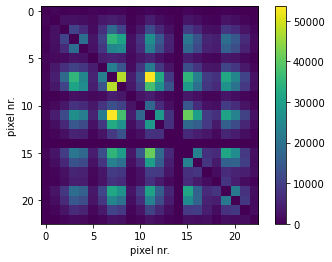

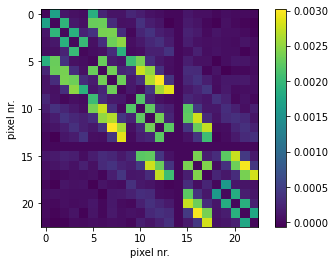

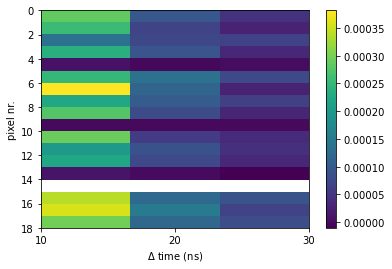

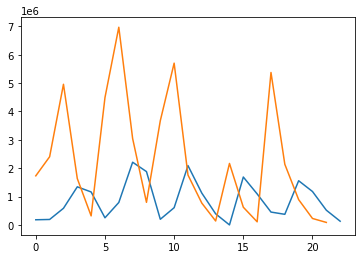

In [49]:
plt.imshow(hist[:,:,100])
plt.xlabel('pixel nr.')
plt.ylabel('pixel nr.')
plt.colorbar()
plt.show()
plt.imshow(correction)
plt.xlabel('pixel nr.')
plt.ylabel('pixel nr.')
plt.colorbar()
plt.show()

plt.imshow(correction_extra,extent=[10,30,18,0],aspect = 'auto')
plt.ylabel('pixel nr.')
plt.xticks([10,20,30])
plt.xlabel('$\Delta$ time (ns)')
plt.colorbar()
plt.show()

plt.plot(counts_detec_1)
plt.plot(counts_detec)

In [48]:
# (G2 correction coefficient)
channels=23
correction = np. zeros((channels,channels))
correction_extra  = np. zeros((18,3))
for i in range(channels):
    for j in range(channels):
        if i!=j:
            correction[i,j] =(hist[i,j,100]- (np.average(hist[i,j,180])/2.+np.average(hist[i,j,20])/2.))/(1.*(counts_detec_1[i]+counts_detec_1[j]))
        if i+5==j:
            print((i,j),hist[i,j,102],(np.average(hist[i,j,180]),np.average(hist[i,j,:25])))
            print((hist[i,j,102]- (np.average(hist[i,j,180])/2.+np.average(hist[i,j,:25])/2.))/(1.*(counts_detec_1[i])))
            print((counts_detec_1[i])*correction_extra[i,0])
            correction_extra [i,0] =(hist[i,j,101]- (np.average(hist[i,j,181])/2.+np.average(hist[i,j,21])/2.))/(1.*(counts_detec_1[i]))
            correction_extra [i,1] =(hist[i,j,102]- (np.average(hist[i,j,182])/2.+np.average(hist[i,j,22])/2.))/(1.*(counts_detec_1[i]))
            correction_extra [i,2] =(hist[i,j,103]- (np.average(hist[i,j,183])/2.+np.average(hist[i,j,23])/2.))/(1.*(counts_detec_1[i]))
        
        
        
#        if i!=j:
#            correction[i,j] =(hist[i,j,100]- (np.average(hist[i,j,175:200])/2.+np.average(hist[i,j,:25])/2.))/(1.*(counts_detec_1[i]+counts_detec_1[j]))
#        if i+5==j:
#            print((i,j),hist[i,j,102],(np.average(hist[i,j,180]),np.average(hist[i,j,:25])))
#            print((hist[i,j,102]- (np.average(hist[i,j,175:200])/2.+np.average(hist[i,j,:25])/2.))/(1.*(counts_detec_1[i])))
#            print((counts_detec_1[i])*correction_extra[i,0])
#            correction_extra [i,0] =(hist[i,j,101]- (np.average(hist[i,j,175:200])/2.+np.average(hist[i,j,:25])/2.))/(1.*(counts_detec_1[i]))
#            correction_extra [i,1] =(hist[i,j,102]- (np.average(hist[i,j,175:200])/2.+np.average(hist[i,j,:25])/2.))/(1.*(counts_detec_1[i]))
#            correction_extra [i,2] =(hist[i,j,103]- (np.average(hist[i,j,175:200])/2.+np.average(hist[i,j,:25])/2.))/(1.*(counts_detec_1[i]))
#joblib.dump((correction,correction_extra,hist),'correction_parameters_dense.pkl')        

(0, 5) 38.0 (74.0, 22.92)
-5.763498211993146e-05
0.0
(1, 6) 18.0 (1312.0, 112.76)
-0.0036142659351870166
0.0
(2, 7) 55.0 (11756.0, 982.84)
-0.010774504651464374
0.0
(3, 8) 142.0 (23175.0, 1921.52)
-0.009236476692270066
0.0
(4, 9) 3.0 (2033.0, 170.04)
-0.0009453122915897566
0.0
(5, 10) 38.0 (1352.0, 114.48)
-0.0027708850619148776
0.0
(6, 11) 109.0 (14953.0, 1270.6)
-0.010117690787652138
0.0
(7, 12) 253.0 (22676.0, 1878.6)
-0.005441317685560866
0.0
(8, 13) 161.0 (6690.0, 557.36)
-0.0018417913035800432
0.0
(9, 14) 0.0 (0.0, 0.0)
0.0
0.0
(10, 15) 44.0 (9351.0, 775.64)
-0.008265343593408565
0.0
(11, 16) 201.0 (20858.0, 1730.48)
-0.005306150562651209
0.0
(12, 17) 92.0 (4653.0, 389.96)
-0.0021660706468486736
0.0
(13, 18) 6.0 (1356.0, 107.92)
-0.0018546734726203433
0.0
(14, 19) 0.0 (0.0, 0.0)
nan
0.0
(15, 20) 221.0 (18118.0, 1520.4)
-0.0056846354576930505
0.0
(16, 21) 174.0 (4950.0, 431.92)
-0.002302418355240349
0.0
(17, 22) 57.0 (467.0, 43.56)
-0.0004379023619960468
0.0


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [ ]:
plt.plot(hist[])

In [52]:
#Crosstalk(G2) occurance map
from time import time

def G2_calc(val_addr,val_time,a,delay_range=200):
    """
    calculates G2; requires unwrapped time tags as input
    val_addr - timetag detector 
    val_time - timetag value
    a - number of timetags
    delay_range

    """

    t1 = time()
    hist = np.zeros((23,23,delay_range+1))
    for i in range(a-1):
        b=1    
        diff = val_time[i+b]-val_time[i]

        while diff<=delay_range/2 and diff>=0:
            if val_addr[i]<25 and val_addr[i+1]<25:
                hist[val_addr[i],val_addr[i+b],delay_range//2+diff]+=1
                hist[val_addr[i+b],val_addr[i],delay_range//2-diff]+=1
                b+=1
                try:
                    diff = val_time[i+b]-val_time[i]
                except:
                    break

    t2=time()
    print("calculated g2 over 23 by 23 pixels for 2001 delays in {:.4f} s".format(t2-t1))
    return hist

In [ ]:
def binTags(detnums, timetags, binsize, n_dets=23):
    """
    bin time tags
    detnums - array containing timetag detector numbers, i-th entry is the detector number of i-th timetag
    timetags - array containing timetags, i-th entry is the timetag of i-th detected photon
    binsize - size of timebin in respective units
    """
    
    num_tags = timetags.shape[0]
    result = np.zeros((n_dets, timetags.max()//binsize+2))
    j = 0
    for i in range(num_tags):

        while j*binsize < timetags[i]:
            j += 1
        result[detnums[i],j] += 1
    
    return result


def calc_corr(arr,i,j,delay):
    """
    i is shifted forward by delay w.r.t j
    """
    if delay == 0 :
        return (arr[i,:]*arr[j,:]).sum()
    else:
        return (arr[i,delay:] * arr[j,:-delay]).sum()
    
def calc_g2_binned(arr,delay_range):
    
    res = np.zeros((23,23,delay_range+1))
    
    for i in range(23):
        for j in range(23):
            for d in range(delay_range+1):
                res[i,j,d] = calc_corr(arr,i,j,d)

    return res

binned = binTags(val_addr, val_time, 10)
g2_binned_test = calc_g2_binned(binned, 100)

(23, 1209632)


In [ ]:
plt.plot(g2_binned_test.sum(axis=(0,1)))
#plt.ylim([20000,22000])
plt.show()

plt.imshow(g2_binned_test[:,:,100])
plt.colorbar()
plt.show()

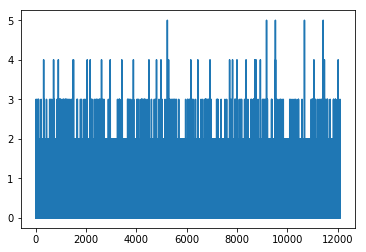

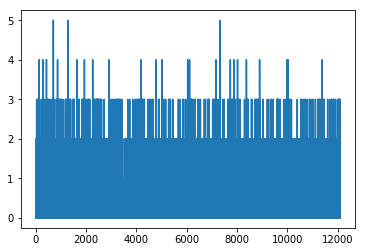

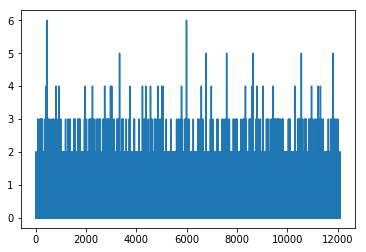

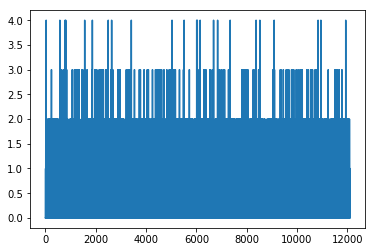

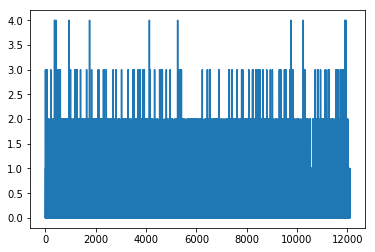

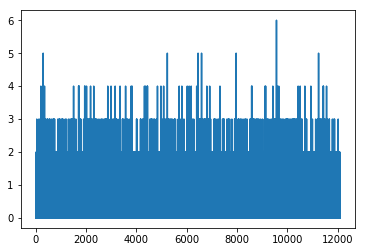

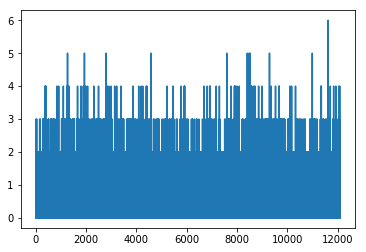

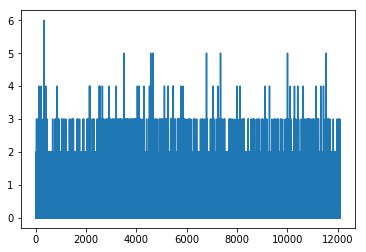

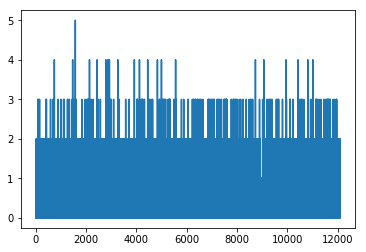

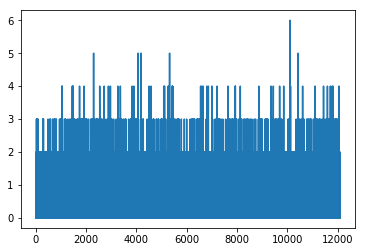

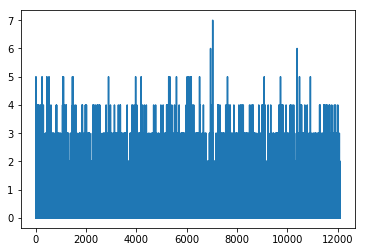

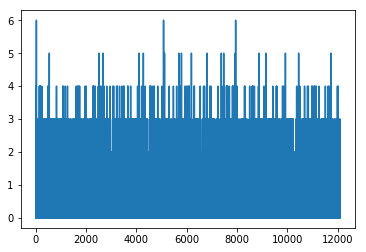

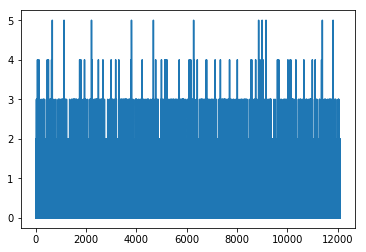

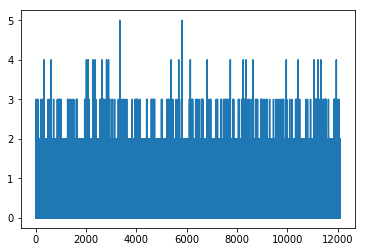

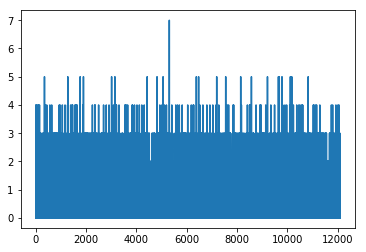

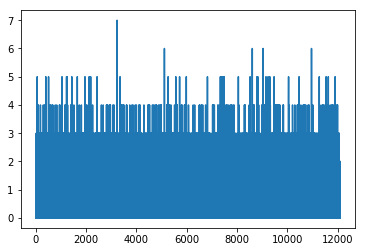

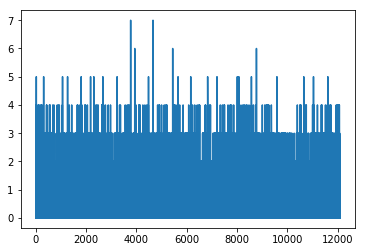

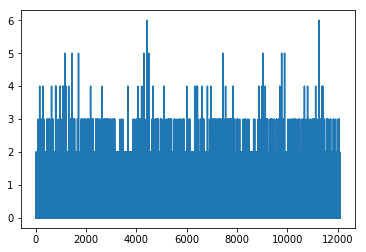

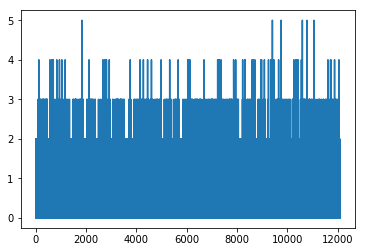

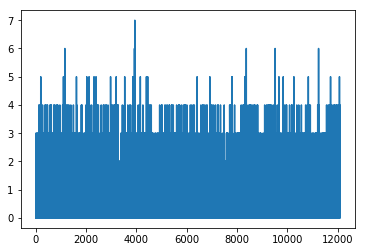

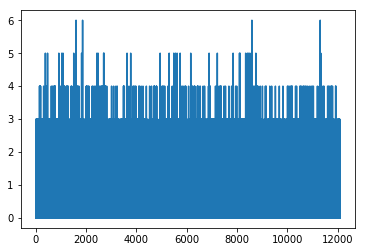

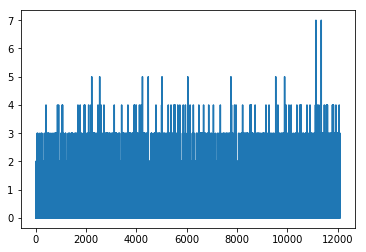

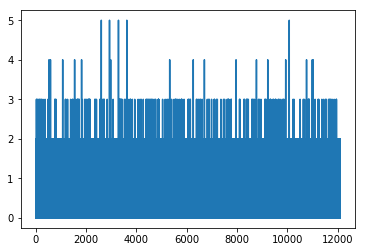

In [77]:
for i in range(23):
    plt.plot(binned[i,:])
    plt.show()

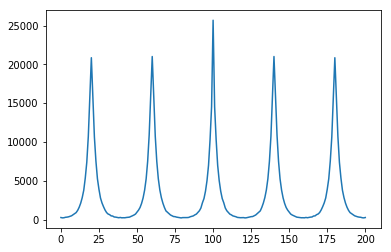

In [54]:
plt.plot(G2_test.sum(axis=(0,1)))
#plt.ylim([20000,22000])
plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


In [53]:
G2_test=G2_calc(val_addr,val_time,200000)

calculated g2 over 23 by 23 pixels for 2001 delays in 4.6850 s


In [17]:
# (G2 correction coefficient for laser)
correction = np. zeros((23,23))
correction_extra  = np. zeros((18,3))
for i in range(23):
    for j in range(23):
        if i!=j:
            correction[i,j] =(hist[i,j,100]- (hist[i,j,180]/2.+hist[i,j,20]/2.))/(1.*(counts_detec[i]+counts_detec[j]))
        if i+5==j:

            correction_extra [i,0] =(hist[i,j,101]- (hist[i,j,181]/2.+hist[i,j,21]/2.))/(1.*(counts_detec[i]))
            correction_extra [i,1] =(hist[i,j,102]- (hist[i,j,182]/2.+hist[i,j,22]/2.))/(1.*(counts_detec[i]))
            correction_extra [i,2] =(hist[i,j,103]- (hist[i,j,183]/2.+hist[i,j,23]/2.))/(1.*(counts_detec[i]))
joblib.dump((correction,correction_extra),'correction_parameters_laser.pkl')       

['correction_parameters_laser.pkl']

In [9]:
(correction,correction_extra)= joblib.load('correction_parameters_laser.pkl')

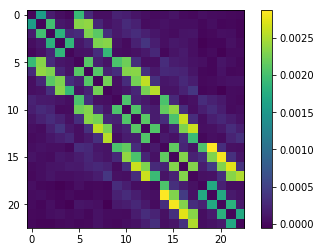

In [655]:
#calculation of first neighbor average coefficient
plt.imshow(correction)
plt.colorbar()
plt.show()
first_nei_sum_one  = np.concatenate((np.diag(correction,k=1)[:4],np.diag(correction,k=1)[5:8],\
                            np.diag(correction,k=1)[9:13],np.diag(correction,k=1)[14:17],\
                            np.diag(correction,k=1)[18:]))
first_nei_sum_four = np.concatenate((np.diag(correction,k=1)[1:9],np.diag(correction,k=1)[10:-1]))
first_nei_sum_five = np.concatenate((np.diag(correction,k=1)[:4],np.diag(correction,k=1)[5:13],\
                            np.diag(correction,k=1)[-4:]))
first_nei = np.concatenate((first_nei_sum_five,first_nei_sum_four,first_nei_sum_one))

In [468]:
print(np.average(first_nei),np.std(first_nei)) # first neighbor mean coefficitent and standard deviation

0.0017571848671031499 0.0006463129355437507


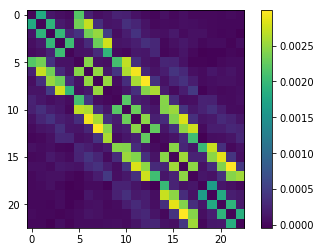

In [18]:
#Correcting coefficient
plt.imshow((correction[:,:]))
plt.colorbar()
plt.show()

hist_corrected = np.copy(hist)
for i in range(23):
    for j in range(23):
        if i!=j:
            hist_corrected[i,j,100] -=(counts_detec[i]+counts_detec[j])*correction[i,j]
        if i+5==j:
            hist_corrected[i,j,101] -=(counts_detec[i])*correction_extra[i,0]
            hist_corrected[j,i,99] -=(counts_detec[i])*correction_extra[i,0]            
            hist_corrected[i,j,102] -=(counts_detec[i])*correction_extra[i,1]
            hist_corrected[j,i,98] -=(counts_detec[i])*correction_extra[i,1]
            hist_corrected[i,j,103] -=(counts_detec[i])*correction_extra[i,2]
            hist_corrected[j,i,97] -=(counts_detec[i])*correction_extra[i,2]

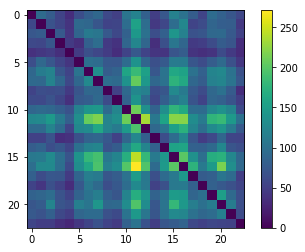

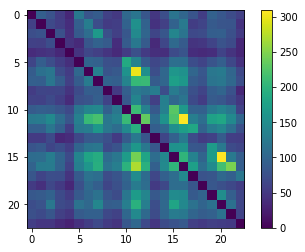

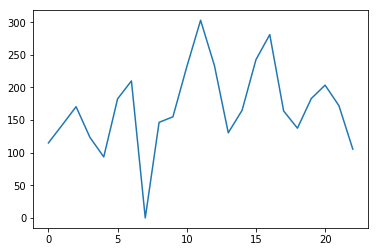

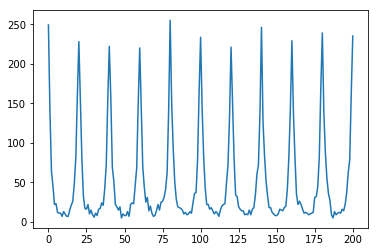

In [19]:
plt.imshow((hist_corrected[:,:,101]))
plt.colorbar()
plt.show()
plt.imshow((hist[:,:,101]))
plt.colorbar()
plt.show()


plt.plot(hist_corrected[7,:,100])
plt.show()
plt.plot((hist_corrected[7,12,:]))
#plt.plot(hist[12,8,:])
plt.show()

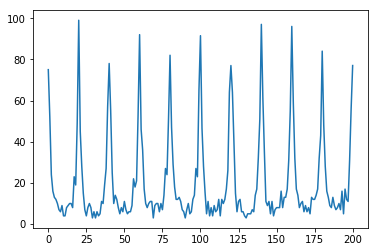

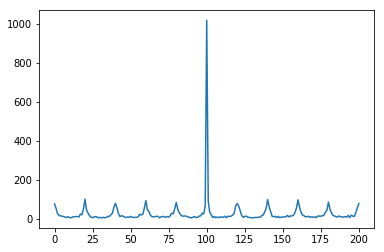

In [20]:
plt.plot(hist_corrected[3,8,:])
plt.show()
plt.plot((hist[3,8,:]))
#plt.plot(hist[12,8,:])
plt.show()

In [13]:
#min dead time calculation
for i in range(23):
    print(i,10*min(np.abs(100-np.where(hist_corrected[i,i,:]>0)[0])),'ns')

0 60 ns
1 60 ns
2 80 ns
3 60 ns
4 60 ns
5 80 ns
6 50 ns
7 80 ns
8 60 ns
9 70 ns
10 50 ns
11 60 ns
12 60 ns
13 70 ns
14 70 ns
15 100 ns
16 60 ns
17 70 ns
18 70 ns
19 60 ns
20 60 ns
21 80 ns
22 70 ns


In [738]:
#min dead time calculation
for i in range(23):
    print(i,10*min(np.abs(100-np.where(hist_corrected[i,i,:]>0)[0])),'ns')

0 90 ns
1 100 ns
2 140 ns
3 100 ns
4 100 ns
5 140 ns
6 80 ns
7 170 ns
8 100 ns
9 110 ns
10 80 ns
11 110 ns
12 100 ns
13 110 ns
14 110 ns
15 190 ns
16 110 ns
17 110 ns
18 130 ns
19 110 ns
20 100 ns
21 170 ns
22 140 ns


In [39]:
# Histogram array cretion
x_points = 11
y_points = 10
channels = 23
pixels = np.zeros((y_points,x_points))
scan_hist = np.zeros((y_points,x_points,channels)) 
lines = np.where(val_addr==31)[0]

if lines.shape ==(0,):
    lines = np.array([0,a])
else:
    lines =np.concatenate((lines,[a]))
for i in range(y_points):
    part = val_addr[lines[i]:lines[i+1]]
    pix = np.concatenate(([0],np.where(part==30)[0],[lines[i+1]-lines[i]]))
    print(pix)
    if i%2==0:
        pixels[i] = lines[i] + pix[:-1]
    else:
        pixels[i] = lines[i] + np.flip(pix[:-1])
    for j in range(x_points):
        scan_hist[i,j] = np.histogram(val_addr[lines[i]+pix[j]:lines[i]+pix[j+1]],bins=channels)[0]
    

[      0  116118  243848  372704  508168  632884  767103  892668 1018927
 1141854 1240041 1326924]
[      0   91332  202722  324569  456090  605562  745110  880085 1023049
 1171842 1299351 1428483]
[      0  143904  282706  416186  555620  695350  838734  988176 1128529
 1266155 1399300 1520285]
[      0  128687  266095  410040  562867  708671  859105 1004473 1161483
 1308648 1451115 1595553]
[      0  142094  303284  462339  626802  793457  949886 1109228 1255293
 1395528 1543824 1670079]
[      0  120416  252380  402132  561863  722442  868155 1051693 1204239
 1363118 1514990 1657646]
[      0  158426  307430  460157  623032  787623  952723 1115532 1280222
 1433702 1553207 1667459]
[      0  114187  251758  400034  540755  676509  839526 1008280 1164822
 1315487 1463864 1592976]
[      0  132550  263412  391047  545824  688147  842199  978435 1115604
 1251138 1378032 1502910]


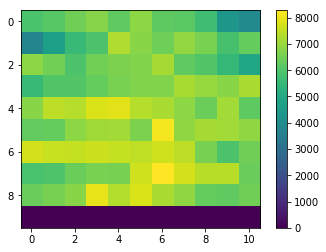

In [40]:
plt.imshow(scan_hist[:,:,0])
plt.colorbar()

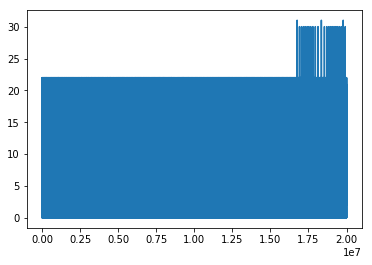

In [33]:
plt.plot(val_addr)